In [745]:
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import torch
from collections import OrderedDict
from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
import flwr as fl
from flwr.common import Metrics
import random
import torch.nn as nn
from typing import Union, Optional
DEVICE = torch.device("cpu")
from tqdm import tqdm

In [627]:
class RegressionData(Dataset):
    def __init__(self, path):
        df = pd.read_csv(path)
        self.x = df[['Periods','appliances']].values
    
    def __len__(self):
        return (len(self.x) // 96) - 8
    
    def __getitem__(self, idx):
        if idx > 358:
            raise Exception('Unbounded window')
        return torch.tensor(self.x[idx*96:(idx+7)*(96)], dtype=torch.float32), torch.tensor(self.x[(idx+7)*96:(idx+8)*96], dtype=torch.float32)

In [897]:
batch_size = 16
num_layers = 2

In [898]:
class MyRNN(nn.Module):
    def __init__(self, hid_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hid_size
        self.rnn = nn.LSTM(input_size=2, hidden_size=self.hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(self.hidden_size, self.hidden_size)
        self.fc2 = nn.Linear(self.hidden_size, 1)
        

    def forward(self, inputs, hidden_state, cell):
        outputs = []
        output, (hidden_states, cell) = self.rnn(inputs, (hidden_state, cell))
        output = self.fc1(output)
        output = nn.functional.relu(output)
        output = self.fc2(output)
        return output, hidden_states, cell

In [931]:
grad_ac = 1
epochs = 1
def train(net, train_loader):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr=3e-4)
    net.train()
    val_losses = []
    for epoch in tqdm(range(epochs)):
        total_loss = 0.0
        for x, Y in train_loader:
            Y = Y.to(DEVICE)
            x = x.to(DEVICE)
            hidden = torch.zeros((num_layers, batch_size, net.hidden_size)).to(DEVICE)
            cell = torch.zeros((num_layers, batch_size, net.hidden_size)).to(DEVICE)
            outs, hidden, cell = net(x, hidden, cell)
            output, _, _ = net(Y, hidden, cell)
            z = torch.cat([outs[:, -1], output[:, :-1].squeeze()], dim=1)
            loss = criterion(Y[:, :, 1], z)
            val_losses.append(loss.item())    
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            #print(f'{loss.item()}\r')
            optimizer.zero_grad()
        print(f'{total_loss / len(train_loader)}')
    return val_losses

In [905]:
train_dataset =  RegressionData(f'./data/Consumer2.csv')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [906]:
model = MyRNN(64).to(DEVICE)

In [907]:
sum([p.numel() for p in model.parameters()])

54913

In [903]:
losses = train(model, train_loader)

  0%|                                                                                                                                                                                                                                                                                                                                               | 0/100 [00:18<?, ?it/s]


KeyboardInterrupt: 

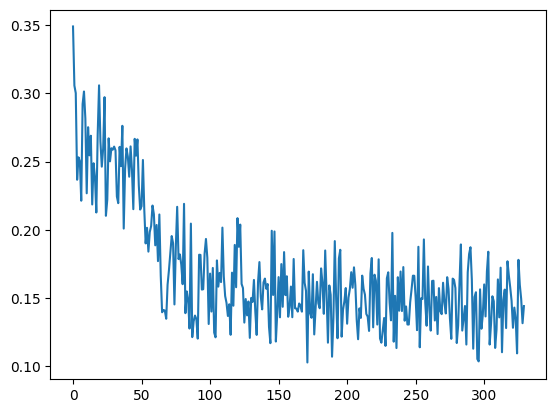

In [884]:
plt.plot(losses)

In [887]:
def test(net, dataset):
    """Train the network on the training set."""
    criterion = torch.nn.MSELoss()
    net.eval()
    val_losses = []
    outputs = []
    with torch.no_grad():
        for i in range(len(dataset)):
            x, Y = dataset[i]
            hidden = torch.zeros((num_layers, net.hidden_size)).to(DEVICE)
            cell = torch.zeros((num_layers, net.hidden_size)).to(DEVICE)
            outs, hidden, cell = net(x, hidden, cell)
            z = [outs[-1].squeeze().item()]
            for i in range(95):
                o, hidden, cell = net(torch.tensor([[i+1, z[-1]]]), hidden, cell)
                z.append(o.item())
            loss = criterion(Y[:, 1], torch.tensor(z))
            val_losses.append(loss.item())
            outputs += z
    return val_losses, outputs

In [888]:
loss, outs = test(model, RegressionData(f'./data/Consumer2.csv'))

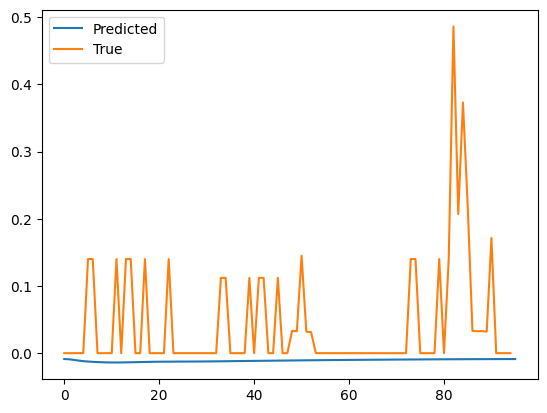

In [889]:
plt.plot(outs[:96], label='Predicted')
plt.plot(eval_dataset[0][1][:95], label='True')
plt.legend()
plt.show()

In [405]:
sum([p.numel() for p in model.parameters()])

46

In [377]:
def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

In [378]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, net, dataset):
        self.net = net
        self.dataset = dataset
        self.losses = []

    def get_parameters(self, config):
        return get_parameters(self.net)

    def fit(self, parameters, config):
        set_parameters(self.net, parameters)
        loss = train(self.net, self.dataset)
        self.losses = loss
        return get_parameters(self.net), len(self.dataset), {'loss': loss}

    def evaluate(self, parameters, config):
        set_parameters(self.net, parameters)
        return 0.0, 1, {}


In [914]:
def client_fn(cid: str) -> FlowerClient:
    """Create a Flower client representing a single organization."""
    # Load model
    cid = int(cid) + 1
    net = MyRNN(hid_size=64).to(DEVICE)
    d = RegressionData(f'./data/Consumer{cid}.csv')
    train_loader = DataLoader(d, batch_size=batch_size, shuffle=True, drop_last=True)

    # Create a  single Flower client representing a single organization
    return FlowerClient(net, train_loader)


In [920]:
class SaveModelStrategy(fl.server.strategy.FedAvg):
    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes]],
        failures: List[Union[Tuple[fl.server.client_proxy.ClientProxy, fl.common.FitRes], BaseException]],
    ):
        """Aggregate model weights using weighted average and store checkpoint"""
        net = MyRNN(hid_size=64).to(DEVICE)

        # Call aggregate_fit from base class (FedAvg) to aggregate parameters and metrics
        aggregated_parameters, aggregated_metrics = super().aggregate_fit(server_round, results, failures)

        if aggregated_parameters is not None:
            print(f"Saving round {server_round} aggregated_parameters...")

            # Convert `Parameters` to `List[np.ndarray]`
            aggregated_ndarrays: List[np.ndarray] = fl.common.parameters_to_ndarrays(aggregated_parameters)

            # Convert `List[np.ndarray]` to PyTorch`state_dict`
            params_dict = zip(net.state_dict().keys(), aggregated_ndarrays)
            state_dict = OrderedDict({k: torch.tensor(v) for k, v in params_dict})
            net.load_state_dict(state_dict, strict=True)

            # Save the model
            torch.save(net.state_dict(), f"model_round_{server_round}.pth")

        return aggregated_parameters, aggregated_metrics

In [937]:
# Create FedAvg strategy
strategy = SaveModelStrategy(
    fraction_fit=0.25,  # Sample 100% of available clients for training
    fraction_evaluate=0.5,  # Sample 50% of available clients for evaluation
    min_fit_clients=10,  # Never sample less than 10 clients for training
    min_evaluate_clients=5,  # Never sample less than 5 clients for evaluation
    min_available_clients=40,  # Wait until all 10 clients are available
)

# Specify client resources if you need GPU (defaults to 1 CPU and 0 GPU)
client_resources = None
if DEVICE.type == "cuda":
    client_resources = {"num_gpus": 1}

# Start simulation
fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=40,
    config=fl.server.ServerConfig(num_rounds=100),
    strategy=strategy,
    client_resources=client_resources,
)


INFO flwr 2023-10-31 15:24:29,158 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2023-10-31 15:24:34,483	INFO worker.py:1642 -- Started a local Ray instance.
INFO flwr 2023-10-31 15:24:34,967 | app.py:210 | Flower VCE: Ray initialized with resources: {'memory': 8290469479.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'memory': 8290469479.0, 'node:127.0.0.1': 1.0, 'CPU': 8.0, 'node:__internal_head__': 1.0, 'object_store_memory': 2147483648.0}
INFO flwr 2023-10-31 15:24:34,967 | app.py:218 | No `client_resources` specified. Using minimal resources for clients.
INFO:flwr:No `client_resources` specified. Using minimal resources for clients.
INFO flwr 2023-10-31 15:24:34,968 | app.py:224 | Flower VCE: Resources for each Virtual Clie

(DefaultActor pid=96820) 0.5160159278999675


DEBUG flwr 2023-10-31 15:24:44,620 | server.py:236 | fit_round 1 received 10 results and 0 failures
DEBUG:flwr:fit_round 1 received 10 results and 0 failures
WARNING flwr 2023-10-31 15:24:44,632 | fedavg.py:242 | No fit_metrics_aggregation_fn provided
DEBUG flwr 2023-10-31 15:24:44,638 | server.py:173 | evaluate_round 1: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 1: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:24:44,823 | server.py:187 | evaluate_round 1 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 1 received 20 results and 0 failures
WARNING flwr 2023-10-31 15:24:44,824 | fedavg.py:273 | No evaluate_metrics_aggregation_fn provided
DEBUG flwr 2023-10-31 15:24:44,824 | server.py:222 | fit_round 2: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 2: strategy sampled 10 clients (out of 40)


Saving round 1 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96819) 0.2897397828373042 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:24:52,444 | server.py:236 | fit_round 2 received 10 results and 0 failures
DEBUG:flwr:fit_round 2 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:24:52,457 | server.py:173 | evaluate_round 2: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 2: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:24:52,606 | server.py:187 | evaluate_round 2 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 2 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:24:52,606 | server.py:222 | fit_round 3: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 3: strategy sampled 10 clients (out of 40)


Saving round 2 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.22926297241991217 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:25:00,390 | server.py:236 | fit_round 3 received 10 results and 0 failures
DEBUG:flwr:fit_round 3 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:25:00,404 | server.py:173 | evaluate_round 3: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 3: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:25:00,535 | server.py:187 | evaluate_round 3 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 3 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:25:00,535 | server.py:222 | fit_round 4: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 4: strategy sampled 10 clients (out of 40)


Saving round 3 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.17415507611903278 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:25:08,047 | server.py:236 | fit_round 4 received 10 results and 0 failures
DEBUG:flwr:fit_round 4 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:25:08,061 | server.py:173 | evaluate_round 4: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 4: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:25:08,189 | server.py:187 | evaluate_round 4 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 4 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:25:08,189 | server.py:222 | fit_round 5: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 5: strategy sampled 10 clients (out of 40)


Saving round 4 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.14453827352686363 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:25:15,691 | server.py:236 | fit_round 5 received 10 results and 0 failures
DEBUG:flwr:fit_round 5 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:25:15,703 | server.py:173 | evaluate_round 5: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 5: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:25:15,826 | server.py:187 | evaluate_round 5 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 5 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:25:15,827 | server.py:222 | fit_round 6: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 6: strategy sampled 10 clients (out of 40)


Saving round 5 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96819) 0.2568065585060553 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:25:23,275 | server.py:236 | fit_round 6 received 10 results and 0 failures
DEBUG:flwr:fit_round 6 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:25:23,290 | server.py:173 | evaluate_round 6: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 6: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:25:23,422 | server.py:187 | evaluate_round 6 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 6 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:25:23,423 | server.py:222 | fit_round 7: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 7: strategy sampled 10 clients (out of 40)


Saving round 6 aggregated_parameters...
(DefaultActor pid=96817) 0.2300977808508006 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-10-31 15:25:30,905 | server.py:236 | fit_round 7 received 10 results and 0 failures
DEBUG:flwr:fit_round 7 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:25:30,918 | server.py:173 | evaluate_round 7: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 7: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:25:31,040 | server.py:187 | evaluate_round 7 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 7 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:25:31,041 | server.py:222 | fit_round 8: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 8: strategy sampled 10 clients (out of 40)


Saving round 7 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.11489843644879082 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:25:38,525 | server.py:236 | fit_round 8 received 10 results and 0 failures
DEBUG:flwr:fit_round 8 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:25:38,538 | server.py:173 | evaluate_round 8: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 8: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:25:38,658 | server.py:187 | evaluate_round 8 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 8 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:25:38,659 | server.py:222 | fit_round 9: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 9: strategy sampled 10 clients (out of 40)


Saving round 8 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96822) 0.27215048467571085 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:25:46,152 | server.py:236 | fit_round 9 received 10 results and 0 failures
DEBUG:flwr:fit_round 9 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:25:46,165 | server.py:173 | evaluate_round 9: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 9: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:25:46,285 | server.py:187 | evaluate_round 9 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 9 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:25:46,286 | server.py:222 | fit_round 10: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 10: strategy sampled 10 clients (out of 40)


Saving round 9 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.08451289209452542 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:25:53,758 | server.py:236 | fit_round 10 received 10 results and 0 failures
DEBUG:flwr:fit_round 10 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:25:53,770 | server.py:173 | evaluate_round 10: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 10: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:25:53,889 | server.py:187 | evaluate_round 10 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 10 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:25:53,889 | server.py:222 | fit_round 11: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 11: strategy sampled 10 clients (out of 40)


Saving round 10 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96822) 0.43096969615329395 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:26:01,373 | server.py:236 | fit_round 11 received 10 results and 0 failures
DEBUG:flwr:fit_round 11 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:26:01,386 | server.py:173 | evaluate_round 11: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 11: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:26:01,507 | server.py:187 | evaluate_round 11 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 11 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:26:01,508 | server.py:222 | fit_round 12: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 12: strategy sampled 10 clients (out of 40)


Saving round 11 aggregated_parameters...
(DefaultActor pid=96820) 0.3247008540413596 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-10-31 15:26:09,190 | server.py:236 | fit_round 12 received 10 results and 0 failures
DEBUG:flwr:fit_round 12 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:26:09,205 | server.py:173 | evaluate_round 12: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 12: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:26:09,332 | server.py:187 | evaluate_round 12 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 12 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:26:09,333 | server.py:222 | fit_round 13: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 13: strategy sampled 10 clients (out of 40)


Saving round 12 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96820) 0.22383987497199664 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:26:16,919 | server.py:236 | fit_round 13 received 10 results and 0 failures
DEBUG:flwr:fit_round 13 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:26:16,932 | server.py:173 | evaluate_round 13: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 13: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:26:17,055 | server.py:187 | evaluate_round 13 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 13 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:26:17,055 | server.py:222 | fit_round 14: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 14: strategy sampled 10 clients (out of 40)


Saving round 13 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96822) 0.05004081350158562 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:26:24,649 | server.py:236 | fit_round 14 received 10 results and 0 failures
DEBUG:flwr:fit_round 14 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:26:24,661 | server.py:173 | evaluate_round 14: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 14: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:26:24,792 | server.py:187 | evaluate_round 14 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 14 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:26:24,792 | server.py:222 | fit_round 15: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 15: strategy sampled 10 clients (out of 40)


Saving round 14 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96819) 0.09874324094165456 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:26:32,300 | server.py:236 | fit_round 15 received 10 results and 0 failures
DEBUG:flwr:fit_round 15 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:26:32,312 | server.py:173 | evaluate_round 15: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 15: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:26:32,437 | server.py:187 | evaluate_round 15 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 15 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:26:32,438 | server.py:222 | fit_round 16: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 16: strategy sampled 10 clients (out of 40)


Saving round 15 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.4461379091848027 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:26:39,961 | server.py:236 | fit_round 16 received 10 results and 0 failures
DEBUG:flwr:fit_round 16 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:26:39,974 | server.py:173 | evaluate_round 16: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 16: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:26:40,097 | server.py:187 | evaluate_round 16 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 16 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:26:40,098 | server.py:222 | fit_round 17: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 17: strategy sampled 10 clients (out of 40)


Saving round 16 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.0792902826585553 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:26:47,603 | server.py:236 | fit_round 17 received 10 results and 0 failures
DEBUG:flwr:fit_round 17 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:26:47,616 | server.py:173 | evaluate_round 17: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 17: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:26:47,737 | server.py:187 | evaluate_round 17 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 17 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:26:47,738 | server.py:222 | fit_round 18: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 18: strategy sampled 10 clients (out of 40)


Saving round 17 aggregated_parameters...
(DefaultActor pid=96820) 0.34397384930740704 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-10-31 15:26:55,381 | server.py:236 | fit_round 18 received 10 results and 0 failures
DEBUG:flwr:fit_round 18 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:26:55,393 | server.py:173 | evaluate_round 18: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 18: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:26:55,517 | server.py:187 | evaluate_round 18 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 18 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:26:55,517 | server.py:222 | fit_round 19: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 19: strategy sampled 10 clients (out of 40)


Saving round 18 aggregated_parameters...
(DefaultActor pid=96817) 0.04639339590953155 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]
DEBUG flwr 2023-10-31 15:27:03,219 | server.py:236 | fit_round 19 received 10 results and 0 failures
DEBUG:flwr:fit_round 19 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:27:03,232 | server.py:173 | evaluate_round 19: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 19: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:27:03,354 | server.py:187 | evaluate_round 19 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 19 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:27:03,354 | server.py:222 | fit_round 20: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 20: strategy sampled 10 clients (out of 40)


Saving round 19 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.21603419293056836 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:27:10,918 | server.py:236 | fit_round 20 received 10 results and 0 failures
DEBUG:flwr:fit_round 20 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:27:10,930 | server.py:173 | evaluate_round 20: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 20: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:27:11,050 | server.py:187 | evaluate_round 20 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 20 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:27:11,051 | server.py:222 | fit_round 21: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 21: strategy sampled 10 clients (out of 40)


Saving round 20 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96822) 0.07725280489433896 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:27:18,737 | server.py:236 | fit_round 21 received 10 results and 0 failures
DEBUG:flwr:fit_round 21 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:27:18,751 | server.py:173 | evaluate_round 21: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 21: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:27:18,879 | server.py:187 | evaluate_round 21 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 21 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:27:18,879 | server.py:222 | fit_round 22: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 22: strategy sampled 10 clients (out of 40)


Saving round 21 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.2593641572377898 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:27:26,678 | server.py:236 | fit_round 22 received 10 results and 0 failures
DEBUG:flwr:fit_round 22 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:27:26,691 | server.py:173 | evaluate_round 22: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 22: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:27:26,818 | server.py:187 | evaluate_round 22 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 22 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:27:26,819 | server.py:222 | fit_round 23: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 23: strategy sampled 10 clients (out of 40)


Saving round 22 aggregated_parameters...
(DefaultActor pid=96820) 0.010609800440513274 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]
DEBUG flwr 2023-10-31 15:27:34,647 | server.py:236 | fit_round 23 received 10 results and 0 failures
DEBUG:flwr:fit_round 23 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:27:34,660 | server.py:173 | evaluate_round 23: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 23: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:27:34,785 | server.py:187 | evaluate_round 23 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 23 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:27:34,785 | server.py:222 | fit_round 24: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 24: strategy sampled 10 clients (out of 40)


Saving round 23 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.16916406222365118 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:27:42,379 | server.py:236 | fit_round 24 received 10 results and 0 failures
DEBUG:flwr:fit_round 24 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:27:42,393 | server.py:173 | evaluate_round 24: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 24: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:27:42,515 | server.py:187 | evaluate_round 24 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 24 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:27:42,516 | server.py:222 | fit_round 25: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 25: strategy sampled 10 clients (out of 40)


Saving round 24 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96822) 0.041566699827936565 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:27:50,181 | server.py:236 | fit_round 25 received 10 results and 0 failures
DEBUG:flwr:fit_round 25 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:27:50,194 | server.py:173 | evaluate_round 25: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 25: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:27:50,319 | server.py:187 | evaluate_round 25 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 25 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:27:50,320 | server.py:222 | fit_round 26: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 26: strategy sampled 10 clients (out of 40)


Saving round 25 aggregated_parameters...
(DefaultActor pid=96817) 0.057388029653917656 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]
DEBUG flwr 2023-10-31 15:27:58,155 | server.py:236 | fit_round 26 received 10 results and 0 failures
DEBUG:flwr:fit_round 26 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:27:58,168 | server.py:173 | evaluate_round 26: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 26: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:27:58,289 | server.py:187 | evaluate_round 26 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 26 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:27:58,289 | server.py:222 | fit_round 27: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 27: strategy sampled 10 clients (out of 40)


Saving round 26 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.24467554891651327 [repeated 11x across cluster]


DEBUG flwr 2023-10-31 15:28:06,195 | server.py:236 | fit_round 27 received 10 results and 0 failures
DEBUG:flwr:fit_round 27 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:28:06,208 | server.py:173 | evaluate_round 27: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 27: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:28:06,334 | server.py:187 | evaluate_round 27 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 27 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:28:06,335 | server.py:222 | fit_round 28: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 28: strategy sampled 10 clients (out of 40)


Saving round 27 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96822) 0.2734538052569736 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:28:14,123 | server.py:236 | fit_round 28 received 10 results and 0 failures
DEBUG:flwr:fit_round 28 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:28:14,136 | server.py:173 | evaluate_round 28: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 28: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:28:14,260 | server.py:187 | evaluate_round 28 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 28 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:28:14,261 | server.py:222 | fit_round 29: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 29: strategy sampled 10 clients (out of 40)


Saving round 28 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.24050269546833905 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:28:22,123 | server.py:236 | fit_round 29 received 10 results and 0 failures
DEBUG:flwr:fit_round 29 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:28:22,136 | server.py:173 | evaluate_round 29: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 29: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:28:22,260 | server.py:187 | evaluate_round 29 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 29 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:28:22,260 | server.py:222 | fit_round 30: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 30: strategy sampled 10 clients (out of 40)


Saving round 29 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96820) 0.009386223222298378 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:28:29,975 | server.py:236 | fit_round 30 received 10 results and 0 failures
DEBUG:flwr:fit_round 30 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:28:29,989 | server.py:173 | evaluate_round 30: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 30: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:28:30,117 | server.py:187 | evaluate_round 30 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 30 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:28:30,118 | server.py:222 | fit_round 31: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 31: strategy sampled 10 clients (out of 40)


Saving round 30 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96819) 0.2148346189748157 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:28:38,071 | server.py:236 | fit_round 31 received 10 results and 0 failures
DEBUG:flwr:fit_round 31 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:28:38,086 | server.py:173 | evaluate_round 31: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 31: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:28:38,229 | server.py:187 | evaluate_round 31 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 31 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:28:38,230 | server.py:222 | fit_round 32: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 32: strategy sampled 10 clients (out of 40)


Saving round 31 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.06499973853880708 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:28:46,136 | server.py:236 | fit_round 32 received 10 results and 0 failures
DEBUG:flwr:fit_round 32 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:28:46,149 | server.py:173 | evaluate_round 32: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 32: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:28:46,275 | server.py:187 | evaluate_round 32 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 32 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:28:46,276 | server.py:222 | fit_round 33: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 33: strategy sampled 10 clients (out of 40)


Saving round 32 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96822) 0.156392747705633 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:28:54,302 | server.py:236 | fit_round 33 received 10 results and 0 failures
DEBUG:flwr:fit_round 33 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:28:54,315 | server.py:173 | evaluate_round 33: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 33: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:28:54,450 | server.py:187 | evaluate_round 33 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 33 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:28:54,451 | server.py:222 | fit_round 34: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 34: strategy sampled 10 clients (out of 40)


Saving round 33 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.10048601471564987 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:29:02,376 | server.py:236 | fit_round 34 received 10 results and 0 failures
DEBUG:flwr:fit_round 34 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:29:02,391 | server.py:173 | evaluate_round 34: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 34: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:29:02,528 | server.py:187 | evaluate_round 34 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 34 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:29:02,528 | server.py:222 | fit_round 35: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 35: strategy sampled 10 clients (out of 40)


Saving round 34 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96822) 0.007965389660305598 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:29:10,643 | server.py:236 | fit_round 35 received 10 results and 0 failures
DEBUG:flwr:fit_round 35 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:29:10,655 | server.py:173 | evaluate_round 35: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 35: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:29:10,783 | server.py:187 | evaluate_round 35 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 35 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:29:10,783 | server.py:222 | fit_round 36: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 36: strategy sampled 10 clients (out of 40)


Saving round 35 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.06536321985450658 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:29:18,724 | server.py:236 | fit_round 36 received 10 results and 0 failures
DEBUG:flwr:fit_round 36 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:29:18,740 | server.py:173 | evaluate_round 36: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 36: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:29:18,872 | server.py:187 | evaluate_round 36 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 36 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:29:18,873 | server.py:222 | fit_round 37: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 37: strategy sampled 10 clients (out of 40)


Saving round 36 aggregated_parameters...
(DefaultActor pid=96820) 0.061383503235199234 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-10-31 15:29:26,726 | server.py:236 | fit_round 37 received 10 results and 0 failures
DEBUG:flwr:fit_round 37 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:29:26,739 | server.py:173 | evaluate_round 37: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 37: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:29:26,869 | server.py:187 | evaluate_round 37 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 37 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:29:26,870 | server.py:222 | fit_round 38: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 38: strategy sampled 10 clients (out of 40)


Saving round 37 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96820) 0.36363868008960376 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:29:34,960 | server.py:236 | fit_round 38 received 10 results and 0 failures
DEBUG:flwr:fit_round 38 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:29:34,972 | server.py:173 | evaluate_round 38: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 38: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:29:35,100 | server.py:187 | evaluate_round 38 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 38 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:29:35,101 | server.py:222 | fit_round 39: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 39: strategy sampled 10 clients (out of 40)


Saving round 38 aggregated_parameters...
(DefaultActor pid=96817) 0.08429027010094035 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]
DEBUG flwr 2023-10-31 15:29:42,994 | server.py:236 | fit_round 39 received 10 results and 0 failures
DEBUG:flwr:fit_round 39 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:29:43,007 | server.py:173 | evaluate_round 39: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 39: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:29:43,141 | server.py:187 | evaluate_round 39 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 39 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:29:43,142 | server.py:222 | fit_round 40: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 40: strategy sampled 10 clients (out of 40)


Saving round 39 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96820) 0.06486109847372229 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:29:51,124 | server.py:236 | fit_round 40 received 10 results and 0 failures
DEBUG:flwr:fit_round 40 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:29:51,140 | server.py:173 | evaluate_round 40: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 40: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:29:51,283 | server.py:187 | evaluate_round 40 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 40 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:29:51,284 | server.py:222 | fit_round 41: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 41: strategy sampled 10 clients (out of 40)


Saving round 40 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96819) 0.3625382726842707 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:29:59,213 | server.py:236 | fit_round 41 received 10 results and 0 failures
DEBUG:flwr:fit_round 41 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:29:59,226 | server.py:173 | evaluate_round 41: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 41: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:29:59,360 | server.py:187 | evaluate_round 41 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 41 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:29:59,361 | server.py:222 | fit_round 42: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 42: strategy sampled 10 clients (out of 40)


Saving round 41 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96820) 0.2744428020986644 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:30:07,674 | server.py:236 | fit_round 42 received 10 results and 0 failures
DEBUG:flwr:fit_round 42 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:30:07,687 | server.py:173 | evaluate_round 42: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 42: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:30:07,830 | server.py:187 | evaluate_round 42 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 42 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:30:07,831 | server.py:222 | fit_round 43: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 43: strategy sampled 10 clients (out of 40)


Saving round 42 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96822) 0.16525169055570255 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:30:16,559 | server.py:236 | fit_round 43 received 10 results and 0 failures
DEBUG:flwr:fit_round 43 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:30:16,575 | server.py:173 | evaluate_round 43: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 43: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:30:16,722 | server.py:187 | evaluate_round 43 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 43 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:30:16,723 | server.py:222 | fit_round 44: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 44: strategy sampled 10 clients (out of 40)


Saving round 43 aggregated_parameters...
(DefaultActor pid=96817) 0.0980907187543132 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-10-31 15:30:24,945 | server.py:236 | fit_round 44 received 10 results and 0 failures
DEBUG:flwr:fit_round 44 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:30:24,959 | server.py:173 | evaluate_round 44: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 44: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:30:25,109 | server.py:187 | evaluate_round 44 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 44 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:30:25,109 | server.py:222 | fit_round 45: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 45: strategy sampled 10 clients (out of 40)


Saving round 44 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.20247649875554172 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:30:33,611 | server.py:236 | fit_round 45 received 10 results and 0 failures
DEBUG:flwr:fit_round 45 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:30:33,623 | server.py:173 | evaluate_round 45: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 45: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:30:33,752 | server.py:187 | evaluate_round 45 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 45 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:30:33,752 | server.py:222 | fit_round 46: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 46: strategy sampled 10 clients (out of 40)


Saving round 45 aggregated_parameters...
(DefaultActor pid=96820) 0.05740331739864566 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-10-31 15:30:42,165 | server.py:236 | fit_round 46 received 10 results and 0 failures
DEBUG:flwr:fit_round 46 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:30:42,180 | server.py:173 | evaluate_round 46: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 46: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:30:42,341 | server.py:187 | evaluate_round 46 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 46 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:30:42,342 | server.py:222 | fit_round 47: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 47: strategy sampled 10 clients (out of 40)


Saving round 46 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.1684874174269763 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:30:50,797 | server.py:236 | fit_round 47 received 10 results and 0 failures
DEBUG:flwr:fit_round 47 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:30:50,811 | server.py:173 | evaluate_round 47: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 47: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:30:50,945 | server.py:187 | evaluate_round 47 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 47 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:30:50,945 | server.py:222 | fit_round 48: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 48: strategy sampled 10 clients (out of 40)


Saving round 47 aggregated_parameters...
(DefaultActor pid=96820) 0.32201020284132525 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]
DEBUG flwr 2023-10-31 15:30:58,960 | server.py:236 | fit_round 48 received 10 results and 0 failures
DEBUG:flwr:fit_round 48 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:30:58,974 | server.py:173 | evaluate_round 48: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 48: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:30:59,101 | server.py:187 | evaluate_round 48 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 48 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:30:59,102 | server.py:222 | fit_round 49: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 49: strategy sampled 10 clients (out of 40)


Saving round 48 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.19338931820609354 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:31:07,336 | server.py:236 | fit_round 49 received 10 results and 0 failures
DEBUG:flwr:fit_round 49 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:31:07,348 | server.py:173 | evaluate_round 49: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 49: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:31:07,478 | server.py:187 | evaluate_round 49 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 49 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:31:07,479 | server.py:222 | fit_round 50: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 50: strategy sampled 10 clients (out of 40)


Saving round 49 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.1424955160103061 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:31:15,610 | server.py:236 | fit_round 50 received 10 results and 0 failures
DEBUG:flwr:fit_round 50 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:31:15,624 | server.py:173 | evaluate_round 50: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 50: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:31:15,754 | server.py:187 | evaluate_round 50 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 50 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:31:15,754 | server.py:222 | fit_round 51: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 51: strategy sampled 10 clients (out of 40)


Saving round 50 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96820) 0.06366498141803524 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:31:23,763 | server.py:236 | fit_round 51 received 10 results and 0 failures
DEBUG:flwr:fit_round 51 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:31:23,776 | server.py:173 | evaluate_round 51: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 51: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:31:23,911 | server.py:187 | evaluate_round 51 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 51 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:31:23,912 | server.py:222 | fit_round 52: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 52: strategy sampled 10 clients (out of 40)


Saving round 51 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96820) 0.21093044497750021 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:31:31,949 | server.py:236 | fit_round 52 received 10 results and 0 failures
DEBUG:flwr:fit_round 52 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:31:31,961 | server.py:173 | evaluate_round 52: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 52: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:31:32,093 | server.py:187 | evaluate_round 52 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 52 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:31:32,094 | server.py:222 | fit_round 53: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 53: strategy sampled 10 clients (out of 40)


Saving round 52 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.09722181375731122 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:31:40,173 | server.py:236 | fit_round 53 received 10 results and 0 failures
DEBUG:flwr:fit_round 53 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:31:40,187 | server.py:173 | evaluate_round 53: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 53: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:31:40,314 | server.py:187 | evaluate_round 53 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 53 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:31:40,315 | server.py:222 | fit_round 54: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 54: strategy sampled 10 clients (out of 40)


Saving round 53 aggregated_parameters...
(DefaultActor pid=96820) 0.36358129571784625 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]
DEBUG flwr 2023-10-31 15:31:48,341 | server.py:236 | fit_round 54 received 10 results and 0 failures
DEBUG:flwr:fit_round 54 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:31:48,355 | server.py:173 | evaluate_round 54: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 54: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:31:48,483 | server.py:187 | evaluate_round 54 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 54 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:31:48,484 | server.py:222 | fit_round 55: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 55: strategy sampled 10 clients (out of 40)


Saving round 54 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.0370301322334192 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:31:56,636 | server.py:236 | fit_round 55 received 10 results and 0 failures
DEBUG:flwr:fit_round 55 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:31:56,648 | server.py:173 | evaluate_round 55: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 55: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:31:56,776 | server.py:187 | evaluate_round 55 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 55 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:31:56,777 | server.py:222 | fit_round 56: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 56: strategy sampled 10 clients (out of 40)


Saving round 55 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.23291683942079544 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:32:04,975 | server.py:236 | fit_round 56 received 10 results and 0 failures
DEBUG:flwr:fit_round 56 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:32:04,989 | server.py:173 | evaluate_round 56: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 56: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:32:05,123 | server.py:187 | evaluate_round 56 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 56 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:32:05,124 | server.py:222 | fit_round 57: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 57: strategy sampled 10 clients (out of 40)


Saving round 56 aggregated_parameters...
(DefaultActor pid=96817) 0.1674312793395736 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-10-31 15:32:13,301 | server.py:236 | fit_round 57 received 10 results and 0 failures
DEBUG:flwr:fit_round 57 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:32:13,316 | server.py:173 | evaluate_round 57: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 57: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:32:13,464 | server.py:187 | evaluate_round 57 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 57 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:32:13,464 | server.py:222 | fit_round 58: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 58: strategy sampled 10 clients (out of 40)


Saving round 57 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96819) 0.0822208510203795 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:32:21,549 | server.py:236 | fit_round 58 received 10 results and 0 failures
DEBUG:flwr:fit_round 58 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:32:21,563 | server.py:173 | evaluate_round 58: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 58: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:32:21,698 | server.py:187 | evaluate_round 58 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 58 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:32:21,699 | server.py:222 | fit_round 59: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 59: strategy sampled 10 clients (out of 40)


Saving round 58 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96820) 0.14412096684629266 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:32:29,617 | server.py:236 | fit_round 59 received 10 results and 0 failures
DEBUG:flwr:fit_round 59 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:32:29,630 | server.py:173 | evaluate_round 59: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 59: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:32:29,757 | server.py:187 | evaluate_round 59 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 59 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:32:29,758 | server.py:222 | fit_round 60: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 60: strategy sampled 10 clients (out of 40)


Saving round 59 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 9x across cluster]


(DefaultActor pid=96819) 0.08057974177328023 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:32:37,829 | server.py:236 | fit_round 60 received 10 results and 0 failures
DEBUG:flwr:fit_round 60 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:32:37,842 | server.py:173 | evaluate_round 60: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 60: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:32:37,971 | server.py:187 | evaluate_round 60 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 60 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:32:37,971 | server.py:222 | fit_round 61: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 61: strategy sampled 10 clients (out of 40)


Saving round 60 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96822) 0.0369365145875649 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:32:46,152 | server.py:236 | fit_round 61 received 10 results and 0 failures
DEBUG:flwr:fit_round 61 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:32:46,164 | server.py:173 | evaluate_round 61: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 61: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:32:46,289 | server.py:187 | evaluate_round 61 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 61 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:32:46,290 | server.py:222 | fit_round 62: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 62: strategy sampled 10 clients (out of 40)


Saving round 61 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96820) 0.24779042127457532 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:32:54,695 | server.py:236 | fit_round 62 received 10 results and 0 failures
DEBUG:flwr:fit_round 62 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:32:54,708 | server.py:173 | evaluate_round 62: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 62: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:32:54,844 | server.py:187 | evaluate_round 62 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 62 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:32:54,844 | server.py:222 | fit_round 63: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 63: strategy sampled 10 clients (out of 40)


Saving round 62 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 11x across cluster]


(DefaultActor pid=96819) 0.2636971270496195 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:33:03,237 | server.py:236 | fit_round 63 received 10 results and 0 failures
DEBUG:flwr:fit_round 63 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:33:03,252 | server.py:173 | evaluate_round 63: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 63: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:33:03,387 | server.py:187 | evaluate_round 63 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 63 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:33:03,388 | server.py:222 | fit_round 64: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 64: strategy sampled 10 clients (out of 40)


Saving round 63 aggregated_parameters...
(DefaultActor pid=96817) 0.09743404320695183 [repeated 10x across cluster]


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]
DEBUG flwr 2023-10-31 15:33:11,625 | server.py:236 | fit_round 64 received 10 results and 0 failures
DEBUG:flwr:fit_round 64 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:33:11,639 | server.py:173 | evaluate_round 64: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 64: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:33:11,767 | server.py:187 | evaluate_round 64 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 64 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:33:11,768 | server.py:222 | fit_round 65: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 65: strategy sampled 10 clients (out of 40)


Saving round 64 aggregated_parameters...


  0%|          | 0/1 [00:00<?, ?it/s] [repeated 10x across cluster]


(DefaultActor pid=96819) 0.16468702493743462 [repeated 10x across cluster]


DEBUG flwr 2023-10-31 15:33:20,121 | server.py:236 | fit_round 65 received 10 results and 0 failures
DEBUG:flwr:fit_round 65 received 10 results and 0 failures
DEBUG flwr 2023-10-31 15:33:20,134 | server.py:173 | evaluate_round 65: strategy sampled 20 clients (out of 40)
DEBUG:flwr:evaluate_round 65: strategy sampled 20 clients (out of 40)
DEBUG flwr 2023-10-31 15:33:20,275 | server.py:187 | evaluate_round 65 received 20 results and 0 failures
DEBUG:flwr:evaluate_round 65 received 20 results and 0 failures
DEBUG flwr 2023-10-31 15:33:20,276 | server.py:222 | fit_round 66: strategy sampled 10 clients (out of 40)
DEBUG:flwr:fit_round 66: strategy sampled 10 clients (out of 40)


Saving round 65 aggregated_parameters...


2023-10-31 15:33:21,343	WARNING worker.py:2058 -- Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 60, in run
 

2023-10-31 15:33:21,370	WARNING worker.py:2058 -- Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 60, in run
 

2023-10-31 15:33:21,391	WARNING worker.py:2058 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff751258c4f55751d2cffe858501000000 Worker ID: 7a6f840e668f9b09eef9ec6e6c13da04f11955dc52923a827f58a69b Node ID: a9c6e46d5ebca734e3d065bcfc0d6acdcc965d8a8b940887ea8ae522 Worker IP address: 127.0.0.1 Worker port: 54491 Worker PID: 96821 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  Fil

2023-10-31 15:33:21,393	WARNING worker.py:2058 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffffdd2f23b10a1b5cf03ff5f6a801000000 Worker ID: e25b0b5030cf96be664bc8cfd56d61c31b60c443c321c8381207fd88 Node ID: a9c6e46d5ebca734e3d065bcfc0d6acdcc965d8a8b940887ea8ae522 Worker IP address: 127.0.0.1 Worker port: 54467 Worker PID: 96819 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  Fil

2023-10-31 15:33:21,395	WARNING worker.py:2058 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff8043382150d33d82d4ca47b701000000 Worker ID: 823334d45ac38000dd7fd3972211d57396670bc720dba56b9fdf240b Node ID: a9c6e46d5ebca734e3d065bcfc0d6acdcc965d8a8b940887ea8ae522 Worker IP address: 127.0.0.1 Worker port: 54508 Worker PID: 96823 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  Fil

2023-10-31 15:33:21,398	WARNING worker.py:2058 -- Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 60, in run
 

2023-10-31 15:33:21,400	WARNING worker.py:2058 -- A worker died or was killed while executing a task by an unexpected system error. To troubleshoot the problem, check the logs for the dead worker. RayTask ID: ffffffffffffffff3d47af15bdc9ce6fb617c2f101000000 Worker ID: 5f6d5fe830e30832249bf525406ae40e80ed4416b8138ea95566bce8 Node ID: a9c6e46d5ebca734e3d065bcfc0d6acdcc965d8a8b940887ea8ae522 Worker IP address: 127.0.0.1 Worker port: 54481 Worker PID: 96820 Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  Fil

ERROR:flwr:The actor died unexpectedly before finishing this task.
	class_name: DefaultActor
	actor_id: 27c38607231cdb6cadd1385901000000
	pid: 96822
	namespace: 24de89f5-a1c6-489f-93ed-7bbf57c4221a
	ip: 127.0.0.1
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_

ERROR:flwr:The actor died unexpectedly before finishing this task.
	class_name: DefaultActor
	actor_id: 3d47af15bdc9ce6fb617c2f101000000
	pid: 96820
	namespace: 24de89f5-a1c6-489f-93ed-7bbf57c4221a
	ip: 127.0.0.1
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_

ERROR flwr 2023-10-31 15:33:21,404 | ray_actor.py:290 | The actor died unexpectedly before finishing this task.
	class_name: DefaultActor
	actor_id: 828341bca9cabddb80389c1201000000
	pid: 96816
	namespace: 24de89f5-a1c6-489f-93ed-7bbf57c4221a
	ip: 127.0.0.1
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_priv

ERROR:flwr:Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 295, in _fetch_future_result
    raise ex
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    retu

ERROR:flwr:The actor died unexpectedly before finishing this task.
	class_name: DefaultActor
	actor_id: 27c38607231cdb6cadd1385901000000
	pid: 96822
	namespace: 24de89f5-a1c6-489f-93ed-7bbf57c4221a
	ip: 127.0.0.1
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_

WARNING flwr 2023-10-31 15:33:21,410 | ray_actor.py:311 | Actor(8043382150d33d82d4ca47b701000000) will be remove from pool.
ERROR flwr 2023-10-31 15:33:21,411 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 295, in _fetch_future_result
    raise ex
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", 

ERROR:flwr:Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 295, in _fetch_future_result
    raise ex
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    retu

ERROR:flwr:The actor died unexpectedly before finishing this task.
	class_name: DefaultActor
	actor_id: 8043382150d33d82d4ca47b701000000
	pid: 96823
	namespace: 24de89f5-a1c6-489f-93ed-7bbf57c4221a
	ip: 127.0.0.1
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_

ERROR flwr 2023-10-31 15:33:21,414 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 295, in _fetch_future_result
    raise ex
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private

ERROR:flwr:Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 295, in _fetch_future_result
    raise ex
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    retu

ERROR:flwr:The actor died unexpectedly before finishing this task.
	class_name: DefaultActor
	actor_id: 8043382150d33d82d4ca47b701000000
	pid: 96823
	namespace: 24de89f5-a1c6-489f-93ed-7bbf57c4221a
	ip: 127.0.0.1
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_

ERROR:flwr:The actor died unexpectedly before finishing this task.
	class_name: DefaultActor
	actor_id: 27c38607231cdb6cadd1385901000000
	pid: 96822
	namespace: 24de89f5-a1c6-489f-93ed-7bbf57c4221a
	ip: 127.0.0.1
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_

WARNING flwr 2023-10-31 15:33:21,417 | ray_actor.py:311 | Actor(828341bca9cabddb80389c1201000000) will be remove from pool.
ERROR flwr 2023-10-31 15:33:21,418 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 295, in _fetch_future_result
    raise ex
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", 

ERROR flwr 2023-10-31 15:33:21,419 | ray_client_proxy.py:148 | The actor died unexpectedly before finishing this task.
	class_name: DefaultActor
	actor_id: dd2f23b10a1b5cf03ff5f6a801000000
	pid: 96819
	namespace: 24de89f5-a1c6-489f-93ed-7bbf57c4221a
	ip: 127.0.0.1
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ra

ERROR:flwr:Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 295, in _fetch_future_result
    raise ex
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    retu

2023-10-31 15:33:21,444	WARNING worker.py:2058 -- Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
    return method(__ray_actor, *args, **kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/util/tracing/tracing_helper.py", line 467, in _resume_span
    return method(self, *_args, **_kwargs)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 60, in run
 

KeyboardInterrupt: 

WARNING flwr 2023-10-31 15:33:21,517 | ray_actor.py:311 | Actor(435d047cb164f85e339441d901000000) will be remove from pool.
ERROR flwr 2023-10-31 15:33:21,535 | ray_client_proxy.py:147 | Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_client_proxy.py", line 140, in _submit_job
    res = self.actor_pool.get_client_result(self.cid, timeout)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 402, in get_client_result
    return self._fetch_future_result(cid)
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 295, in _fetch_future_result
    raise ex
  File "/opt/homebrew/lib/python3.10/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 288, in _fetch_future_result
    res_cid, res = ray.get(future)  # type: (str, ClientRes)
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", 

ERROR:flwr:The actor died unexpectedly before finishing this task.
	class_name: DefaultActor
	actor_id: 435d047cb164f85e339441d901000000
	pid: 96818
	namespace: 24de89f5-a1c6-489f-93ed-7bbf57c4221a
	ip: 127.0.0.1
The actor is dead because its worker process has died. Worker exit type: SYSTEM_ERROR Worker exit detail: Worker exits unexpectedly. Worker exits with an exit code None.
 Traceback (most recent call last):
  File "python/ray/_raylet.pyx", line 1894, in ray._raylet.execute_task_with_cancellation_handler
  File "python/ray/_raylet.pyx", line 1558, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1559, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1610, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1616, in ray._raylet.execute_task
  File "python/ray/_raylet.pyx", line 1556, in ray._raylet.execute_task.function_executor
  File "/opt/homebrew/lib/python3.10/site-packages/ray/_private/function_manager.py", line 726, in actor_

In [945]:
net = MyRNN(hid_size=64)
net.load_state_dict(torch.load('./m65.pth'), strict=False)

<All keys matched successfully>

In [952]:
eval_dataset = RegressionData(f'./data/Consumer49.csv')

In [953]:
loss, outs = test(net, eval_dataset)

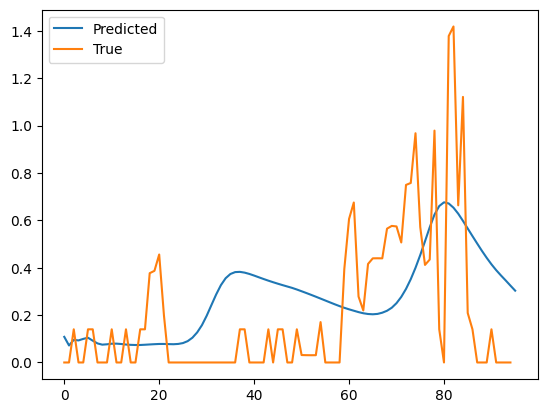

In [954]:
plt.plot(outs[:96], label='Predicted')
plt.plot(eval_dataset[0][1][:95, 1], label='True')
plt.legend()
plt.show()